# **Estimating Firebrand Properties from Multiple Video Cameras**

This notebook contains Prediction of size of Firebrands, The other notebook contains Classification of shape of Firebrands.

In [ ]:
#Importing basic libraries

import numpy as np
import os
import shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix

In [ ]:
#Importing the deeplearning libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from numpy import asarray
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Mounting GoogleDrive to fetch dataset easily

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining all the functions that are needed later on to do certain things

# Function to create volume and surface area of fire bands from lenght width and height

def vol_area(y_train):
  """
  input: takes y which contain parameter like L,W,H and Object shape
  process: calculates the volume and surface area based on the object shape
  output: gives volumes and Surface areas for all the data points in y in form of pandas dataframe
  """
  features=['volume','surfacearea']
  y_train_features=[]
  for i in range(len(y_train['shape'])):
    l=np.array(y_train.L)[i]
    w=np.array(y_train.W)[i]
    h=np.array(y_train.H)[i]
    if np.array(y_train['shape'])[i]=='cub':
      volume=l*w*h
      area=6*l*w
    elif np.array(y_train['shape'])[i]=='sph':
      volume=4/3*3.14*l*w*h/8
      area=4*3.14*l*w/4
    else:
      volume=3.14*l*w*h
      area=2*3.14*h*(w+h)
    y_train_features.append([round(volume), round(area)])
  return pd.DataFrame(y_train_features,columns=features)

import matplotlib.pyplot as plt

# Plotting
# We have used the helper function that was used during session exercise to plot history of regression model

def plot_history(history, name):
  """
  input: takes history of the training of Regression
  process: plots the mse and loss against the epochs
  output: None
  """
  with plt(scale=0.2):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    for i, metric in enumerate(['loss', 'mse']): 
        ax[i].plot(history.history[metric], label='Train', color='r',linewidth=3)
        ax[i].plot(history.history[f'val_{metric}'], label='Validation', color='g',linewidth=3)
        if metric == 'mse': 
          # ax[i].axhline(0.5, color='#8d021f', ls='--', label='Trivial accuracy')
          ax[i].set_ylabel("MSE", fontsize=14)
        else:
          ax[i].set_ylabel("Loss", fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=14)

    plt.suptitle(f'{name} Training', y=1.05, fontsize=16)
    plt.legend(loc='best')
    plt.tight_layout()

# We have used the Helper function that was used during session Exercise to plot history##

def plot_historyc(history, name):
  """
  input: takes history of the training of Classification
  process: plots the Accuracy and loss against the epochs
  output: None
  """
  with plt(scale=0.2):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    for i, metric in enumerate(['loss', 'accuracy']): 
        ax[i].plot(history.history[metric], label='Train', color='r',linewidth=3)
        ax[i].plot(history.history[f'val_{metric}'], label='Validation', color='g',linewidth=3)
        if metric == 'accuracy': 
          # ax[i].axhline(0.5, color='#8d021f', ls='--', label='Trivial accuracy')
          ax[i].set_ylabel("Accuracy", fontsize=14)
        else:
          ax[i].set_ylabel("Loss", fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=14)

    plt.suptitle(f'{name} Training', y=1.05, fontsize=16)
    plt.legend(loc='best')
    plt.tight_layout()

# Function to calculate Mean Squared errors of Response variables

def meansquareerror(ytrue,ypred):
  """
  input: Takes ytrue and prediction on xtrue
  process: calculates the MSE of different parameter like L, W, H, volume, Surfacearea, a, b,c'
  outpur: Gives mse of the parameter in the form of dictionary
  """
  mse={}
  mse['L']=MSE(ytrue.L,ypred.L)
  mse['W']=MSE(ytrue.W,ypred.W)
  mse['H']=MSE(ytrue.H,ypred.H)
  mse['volume']=MSE(ytrue.volume, ypred.volume)
  mse['surfacearea']=MSE(ytrue.surfacearea, ypred.surfacearea)
  mse['a']=MSE(ytrue.a,ypred.a)
  mse['b']=MSE(ytrue.b,ypred.b)
  mse['c']=MSE(ytrue.c,ypred.c)
  return mse

# For plotting mse values of respective variables across all models

def plotmse(inputvar,label):
  data={"Baseline Model 1 & 2":mseA[inputvar], "Model 3":mseB[inputvar], "Model 4":mseC[inputvar]}
  names = list(data.keys())
  values = list(data.values())
  fig = plt.figure(figsize = (10, 5))
  plt.bar(range(len(data)), values, tick_label=names, width = 0.4)
  plt.xlabel("Model Name")
  plt.ylabel("MSE Values")
  plt.title("MSEs for "+ label)
  plt.show()

# Function to plot comparison of true and predicted values

def plotcomparison(inputvar,label):
  data={"Predicted Value":y_pred_randomsample[inputvar], "True Value":y_test_randomsample[inputvar]}
  names = list(data.keys())
  values = list(data.values())
  fig = plt.figure(figsize = (10, 5))
  plt.bar(range(len(data)), values, tick_label=names, width = 0.4)
  plt.xlabel("Value Type")
  plt.ylabel(label + " Values")
  plt.title("Comparison of "+label)
  plt.show()

# **Loading the Data**

Filename – naming convention:
“synth_cyl_L030_W020_H020_X+0785_Y+1021_Z0409_a252_b204_c088_D1_2408_D2_1750_D3_2483_D4_1802.png”

synth_cyl: Shape of the firebrand – Cylindrical

L030: The length of the cylinder is 30 mm.

W020: The width of the cylinder is 20 mm.

H020: The heigh of the cylinder is 20 mm.

X+0785_Y+1021_Z-0409: The X location of the firebrand is 785 mm, Y location of the firebrand is 1021 mm, and the Z location of the firebrand is 409 mm.

a252_b204_c088: 3-D orientation / angle [7] of the firebrand in degrees.

D1_2408: Distance of the firebrand from Camera # 1 is 2408 mm.

D2_1750: Distance of the firebrand from Camera # 2 is 1750 mm.

D3_2483: Distance of the firebrand from Camera # 3 is 2483 mm.

D4_1802: Distance of the firebrand from Camera # 4 is 1802 mm.

In [ ]:
df_train=pd.read_csv('df_train.csv')
df_val=pd.read_csv('df_val.csv')
df_test=pd.read_csv('df_test.csv')

In [ ]:
df_train=pd.read_csv('df_train.csv')
df_val=pd.read_csv('df_val.csv')
df_test=pd.read_csv('df_test.csv')
print('Train df shape:', df_train.shape)
print('Validation df shape:', df_val.shape)
print('Test df shape:', df_test.shape) # test also include additional predicted label column predicted from vgg16 classifier

Train df shape: (5164, 15)
Validation df shape: (645, 15)
Test df shape: (646, 16)


### **Final Classification Model Results**

We can see from the following that the loading of data is such that there are equal proportions of cylinder, cubes and Sphere data points in Train, Validation, Test data set

In [ ]:
print(df_train['shape'].value_counts())
print(df_val['shape'].value_counts())
print(df_test['shape'].value_counts())

cyl    2000
cub    1600
sph    1564
Name: shape, dtype: int64
cyl    250
cub    200
sph    195
Name: shape, dtype: int64
cyl    250
cub    200
sph    196
Name: shape, dtype: int64


In [ ]:
y_pred=df_test['predicted_shape']
y_test=df_test['shape']
y_pred_shape=pd.DataFrame(y_pred)
y_pred_shape.rename(columns = {'predicted_shape':'shape'}, inplace = True)
y_test_shape=pd.DataFrame(y_test)

### **Regression Modelling**

In this Section,we use the above classification model to predict the object shape from the image. We address problem of finding Length(L), Width(W), Height(H), orientation a, b, c, (roll, pitch, yaw), volume, surface area, energy and propensity. This is done by using CNN regression.
This done in three models namely ModelA, ModelB, ModelC

## *ModelA*

ModelA: it consist of 2 submodels namely model1 and model2. These are Baseline models

*   model1 is CNN regression model take inputs as the images and response variable as Length(L), Width(W), Height(H) and used to predict them on test data. We can calculate Volume, Surface area from these predicted variables. 

*   model2 is CNN regression model take inputs as the images and reponse variable as  Orientation a, b ,c and used to predict them on test data

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_set_reg1 = datagen.flow_from_dataframe(
        df_train,
        x_col='img_path',
        y_col=['L','W','H'],
        target_size=(224, 224),
        class_mode='raw',
        batch_size=64)

val_set_reg1 = datagen.flow_from_dataframe(
        df_val,
        x_col='img_path',
        y_col=['L','W','H'],
        target_size=(224, 224),
        class_mode='raw',
        batch_size=64)

test_set_reg1 = datagen.flow_from_dataframe(
        df_test,
        x_col='img_path',
        y_col=['L','W','H'],
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        shuffle = False)

Found 5164 validated image filenames.
Found 645 validated image filenames.
Found 646 validated image filenames.


In [ ]:
# Baseline 1 for prediting L, W, H

batch_size = 64
model1 = Sequential()
model1.add(Conv2D(32,(3,3),padding='same',input_shape=(224,224,3),activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(256,(3,3),padding='same',activation='relu'))
model1.add(MaxPool2D(2,2))
model1.add(Flatten())
model1.add(Dense(64,activation='relu'))
model1.add(Dense(3,activation='linear'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

In [ ]:
#Defining early stopping for regularisation

es=EarlyStopping(restore_best_weights=True, monitor='val_loss', patience=20, verbose=1, mode='min')

In [ ]:
#Compiling Baseline 1 for prediting L, W, H 

model1.compile(loss='mse',metrics=['mse'],optimizer=optimizers.Adam(learning_rate=1e-4))
history1= model1.fit(train_set_reg1,epochs=100,verbose=2,validation_data=val_set_reg1,batch_size=batch_size, callbacks=[es])

Epoch 1/100
81/81 - 1679s - loss: 207.1181 - mse: 207.1181 - val_loss: 59.2026 - val_mse: 59.2026 - 1679s/epoch - 21s/step
Epoch 2/100
81/81 - 15s - loss: 59.0009 - mse: 59.0009 - val_loss: 57.3683 - val_mse: 57.3683 - 15s/epoch - 185ms/step
Epoch 3/100
81/81 - 13s - loss: 57.4681 - mse: 57.4681 - val_loss: 58.2294 - val_mse: 58.2294 - 13s/epoch - 154ms/step
Epoch 4/100
81/81 - 13s - loss: 56.6530 - mse: 56.6530 - val_loss: 54.9831 - val_mse: 54.9831 - 13s/epoch - 155ms/step
Epoch 5/100
81/81 - 12s - loss: 55.2169 - mse: 55.2169 - val_loss: 55.8489 - val_mse: 55.8489 - 12s/epoch - 154ms/step
Epoch 6/100
81/81 - 12s - loss: 53.0286 - mse: 53.0286 - val_loss: 49.9080 - val_mse: 49.9080 - 12s/epoch - 152ms/step
Epoch 7/100
81/81 - 14s - loss: 49.6854 - mse: 49.6854 - val_loss: 46.4859 - val_mse: 46.4859 - 14s/epoch - 170ms/step
Epoch 8/100
81/81 - 12s - loss: 46.7349 - mse: 46.7349 - val_loss: 45.3231 - val_mse: 45.3231 - 12s/epoch - 154ms/step
Epoch 9/100
81/81 - 13s - loss: 46.3526 - ms

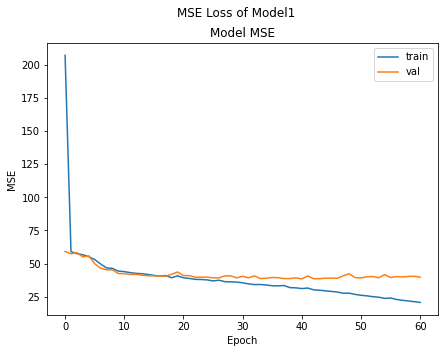

In [ ]:
#Plotting the performance of Baseline Model 1 for prediting L, W, H
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(history1.history['mse'])
ax.plot(history1.history['val_mse'])
ax.set_title('Model MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
fig.suptitle('MSE Loss of Model1')
plt.show()

In [ ]:
#Making predictions based on Baseline Model 1 and calculating the volume and surface area from L,W,H

# y_pred1=model1.predict(x_test)
# y_pred1=pd.DataFrame(y_pred1, columns=['L','W','H'])
y_pred1=model1.predict(test_set_reg1)
y_pred1 = pd.DataFrame(y_pred1,columns=['L','W','H'])
y_test1=df_test[['L','W','H']]

y_pred1=pd.concat([y_pred_shape,y_pred1],axis=1)
y_test1=pd.concat([y_test_shape,y_test1],axis=1)

y_pred1_features=vol_area(y_pred1)
y_test1_features=vol_area(y_test1)

11/11 [==============================] - 169s 17s/step


In [ ]:
#Defining baseline bodel 2 for prediting orientation

batch_size = 64
model2 = Sequential()
model2.add(Conv2D(32,(3,3),padding='same',input_shape=(224,224,3),activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(256,(3,3),padding='same',activation='relu'))
model2.add(MaxPool2D(2,2))
model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dense(3,activation='linear'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 128)     

In [ ]:
train_set_reg2 = datagen.flow_from_dataframe(
        df_train,
        x_col='img_path',
        y_col=['a','b','c'],
        target_size=(224, 224),
        class_mode='raw',
        batch_size=64)

val_set_reg2 = datagen.flow_from_dataframe(
        df_val,
        x_col='img_path',
        y_col=['a','b','c'],
        target_size=(224, 224),
        class_mode='raw',
        batch_size=64)

test_set_reg2 = datagen.flow_from_dataframe(
        df_test,
        x_col='img_path',
        y_col=['a','b','c'],
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        shuffle = False)

Found 5164 validated image filenames.
Found 645 validated image filenames.
Found 646 validated image filenames.


In [ ]:
#Compiling baseline model 2 for prediting orientation

model2.compile(loss='mse',metrics=['mse'],optimizer=optimizers.Adam(learning_rate=1e-4))

history2= model2.fit(train_set_reg2,epochs=100,verbose=2,validation_data=val_set_reg2,batch_size=batch_size, callbacks=[es])

Epoch 1/100
81/81 - 13s - loss: 23015.2656 - mse: 23015.2656 - val_loss: 11665.0156 - val_mse: 11665.0156 - 13s/epoch - 162ms/step
Epoch 2/100
81/81 - 12s - loss: 11086.6660 - mse: 11086.6660 - val_loss: 10973.3945 - val_mse: 10973.3945 - 12s/epoch - 150ms/step
Epoch 3/100
81/81 - 12s - loss: 10908.3193 - mse: 10908.3193 - val_loss: 10868.5234 - val_mse: 10868.5234 - 12s/epoch - 150ms/step
Epoch 4/100
81/81 - 13s - loss: 10872.9971 - mse: 10872.9971 - val_loss: 10873.1123 - val_mse: 10873.1123 - 13s/epoch - 160ms/step
Epoch 5/100
81/81 - 12s - loss: 10867.6357 - mse: 10867.6357 - val_loss: 11063.8486 - val_mse: 11063.8486 - 12s/epoch - 149ms/step
Epoch 6/100
81/81 - 12s - loss: 10948.5107 - mse: 10948.5107 - val_loss: 10927.8857 - val_mse: 10927.8857 - 12s/epoch - 148ms/step
Epoch 7/100
81/81 - 12s - loss: 10864.5537 - mse: 10864.5537 - val_loss: 10823.6582 - val_mse: 10823.6582 - 12s/epoch - 150ms/step
Epoch 8/100
81/81 - 12s - loss: 10862.6895 - mse: 10862.6895 - val_loss: 10975.0703

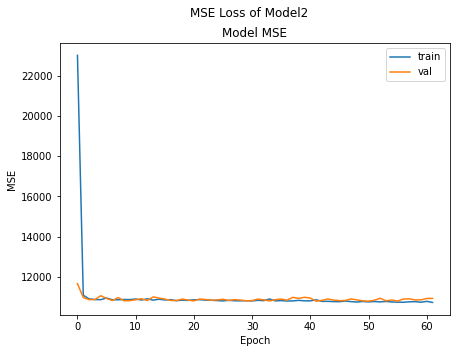

In [ ]:
#Plotting the performance of Baseline Model 1 for prediting Orientation i.e. Model 2

fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(history2.history['mse'])
ax.plot(history2.history['val_mse'])
ax.set_title('Model MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
fig.suptitle('MSE Loss of Model2')
plt.show()

In [ ]:
#Predicting the orientation

y_pred2=model2.predict(test_set_reg2)
y_pred2=pd.DataFrame(y_pred2, columns=['a','b','c'])
y_test2=df_test[['a','b','c']]

11/11 [==============================] - 1s 125ms/step


In [ ]:
#Calculating the MSEs of L,W,H, Volume, surface area, a, b, c

ypredA=pd.concat([y_pred1,y_pred2,y_pred1_features],axis=1)
ytrueA=pd.concat([y_test1,y_test2,y_test1_features],axis=1)
mseA=meansquareerror(ytrueA,ypredA)
print('MSE Loss for model A is')
print(mseA)

MSE Loss for model A is
{'L': 65.85594551256827, 'W': 34.12327759839376, 'H': 34.12677750938775, 'volume': 1764914238.9427245, 'surfacearea': 19120190.781733748, 'a': 11414.941430719999, 'b': 10164.745748371688, 'c': 10762.61590727996}


# *ModelB*

ModelB: it consist of 2 submodels namely model3 and model4. These are improved version of model1 and model2. In these improved model there more number of hidden layer and regularisation was also done in the form of dropout, and L2 regularisation.

*   model3 is CNN regression model take inputs as the images and response variable as Length(L), Width(W), Height(H) and used to predict them on test data. We can calculate Volume, Surface area from these predicted variables. 

*   model4 is CNN regression model take inputs as the images and reponse variable as  Orientation a, b ,c and used to predict them on test data

In [ ]:
#Improved Model i.e. Model 3 with regularistion and given parameters

batch_size = 64
model3 = Sequential()
model3.add(Conv2D(32,(3,3),padding='same',input_shape=(224,224,3),activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(64,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(128,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(256,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(512,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(512,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(MaxPool2D(2,2))
model3.add(Flatten())
model3.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(32,activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model3.add(Dropout(0.2))
model3.add(Dense(3,activation='linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 28, 28, 128)     

In [ ]:
# Compiling the improved model i.e. Model 3 
model3.compile(loss='mse',metrics=['mse'],optimizer=optimizers.Adam(learning_rate=1e-4))

history3= model3.fit(train_set_reg1,epochs=100,verbose=2,validation_data=val_set_reg1,batch_size=batch_size, callbacks=[es])

Epoch 1/100
81/81 - 15s - loss: 297.0454 - mse: 284.1424 - val_loss: 85.8656 - val_mse: 73.3368 - 15s/epoch - 183ms/step
Epoch 2/100
81/81 - 13s - loss: 150.1507 - mse: 137.9423 - val_loss: 86.3967 - val_mse: 74.4837 - 13s/epoch - 155ms/step
Epoch 3/100
81/81 - 13s - loss: 142.4679 - mse: 130.7908 - val_loss: 88.4874 - val_mse: 77.0330 - 13s/epoch - 155ms/step
Epoch 4/100
81/81 - 13s - loss: 135.7407 - mse: 124.4696 - val_loss: 76.3899 - val_mse: 65.2939 - 13s/epoch - 156ms/step
Epoch 5/100
81/81 - 13s - loss: 131.4324 - mse: 120.4867 - val_loss: 71.4409 - val_mse: 60.6419 - 13s/epoch - 154ms/step
Epoch 6/100
81/81 - 13s - loss: 128.6302 - mse: 117.9598 - val_loss: 72.8654 - val_mse: 62.3203 - 13s/epoch - 158ms/step
Epoch 7/100
81/81 - 12s - loss: 124.2748 - mse: 113.8402 - val_loss: 67.5089 - val_mse: 57.1817 - 12s/epoch - 154ms/step
Epoch 8/100
81/81 - 13s - loss: 120.6131 - mse: 110.3857 - val_loss: 67.5701 - val_mse: 57.4379 - 13s/epoch - 155ms/step
Epoch 9/100
81/81 - 13s - loss: 

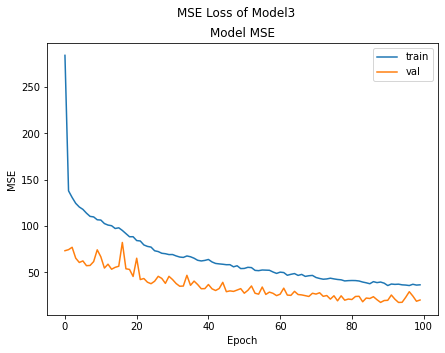

In [ ]:
#Plotting the performance of Improved Modeel i.e. Model 3 
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(history3.history['mse'])
ax.plot(history3.history['val_mse'])
ax.set_title('Model MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
fig.suptitle('MSE Loss of Model3')
plt.show()

In [ ]:
#Making predictions on Model 3 i.e. Improved Model

y_pred3=model3.predict(test_set_reg1)
y_pred3 = pd.DataFrame(y_pred3,columns=['L','W','H'])
y_test3=df_test[['L','W','H']]

y_pred3=pd.concat([y_pred_shape,y_pred3],axis=1)
y_test3=pd.concat([y_test_shape,y_test3],axis=1)

y_pred3_features=vol_area(y_pred3)
y_test3_features=vol_area(y_test3)

11/11 [==============================] - 2s 136ms/step


In [ ]:
#Improved Model i.e. Model 4 with regularistion and given parameters

batch_size = 64
model4 = Sequential()
model4.add(Conv2D(32,(3,3),padding='same',input_shape=(224,224,3),activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(64,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(128,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(256,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(512,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(512,(3,3),padding='same',activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(MaxPool2D(2,2))
model4.add(Flatten())
model4.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(Dropout(0.2))
model4.add(Dense(32,activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model4.add(Dropout(0.2))
model4.add(Dense(3,activation='linear'))
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 28, 128)     

In [ ]:
#Compiling the improved model i.e. Model 4

model4.compile(loss='mse',metrics=['mse'],optimizer=optimizers.Adam(learning_rate=1e-4))
history4= model4.fit(train_set_reg2,epochs=100,verbose=2,validation_data=val_set_reg2,batch_size=batch_size, callbacks=[es])

Epoch 1/100
81/81 - 14s - loss: 22826.6641 - mse: 22813.4727 - val_loss: 11507.8965 - val_mse: 11494.7842 - 14s/epoch - 171ms/step
Epoch 2/100
81/81 - 13s - loss: 13614.9297 - mse: 13601.9160 - val_loss: 11660.2822 - val_mse: 11647.3740 - 13s/epoch - 157ms/step
Epoch 3/100
81/81 - 13s - loss: 13510.3486 - mse: 13497.5166 - val_loss: 10886.9531 - val_mse: 10874.1982 - 13s/epoch - 156ms/step
Epoch 4/100
81/81 - 13s - loss: 13241.2939 - mse: 13228.6074 - val_loss: 11123.6562 - val_mse: 11111.0225 - 13s/epoch - 154ms/step
Epoch 5/100
81/81 - 13s - loss: 13224.7168 - mse: 13212.1328 - val_loss: 10920.6562 - val_mse: 10908.1162 - 13s/epoch - 155ms/step
Epoch 6/100
81/81 - 13s - loss: 12905.8135 - mse: 12893.3164 - val_loss: 10851.2461 - val_mse: 10838.7793 - 13s/epoch - 163ms/step
Epoch 7/100
81/81 - 13s - loss: 12946.5410 - mse: 12934.1152 - val_loss: 10947.9268 - val_mse: 10935.5371 - 13s/epoch - 155ms/step
Epoch 8/100
81/81 - 13s - loss: 13125.9795 - mse: 13113.6250 - val_loss: 10899.2012

In [ ]:
#Plotting the performance of Improved Modeel i.e. Model 4
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(history4.history['mse'])
ax.plot(history4.history['val_mse'])
ax.set_title('Model MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
fig.suptitle('MSE Loss of Model4')
plt.show()

In [ ]:
#Predicting the orientation

y_pred4=model4.predict(test_set_reg2)
y_pred4=pd.DataFrame(y_pred4, columns=['a','b','c'])
y_test4=df_test[['a','b','c']]

In [ ]:
#Calculating the MSEs

ypredB=pd.concat([y_pred3,y_pred4,y_pred3_features],axis=1)
ytrueB=pd.concat([y_test3,y_test4,y_test3_features],axis=1)
mseB=meansquareerror(ytrueB,ypredB)
print('MSE for a,b,c calulation using regression model is')
print(mseB)

### Picking up a randomsample from test set and making predictions

In [ ]:
test_set2 = datagen.flow_from_dataframe(
        df_test,
        x_col='img_path',
        y_col=['L','W','H','a','b','c'],
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        shuffle = False)
x_test = []
y_test = []
for i in range(11):
  x, y = next(test_set2)
  x_test.append(x)
  y_test.append(y)
x_test = np.concatenate([i for i in x_test])
y_test = np.concatenate([i for i in y_test])

print(x_test.shape)
print(y_test.shape)

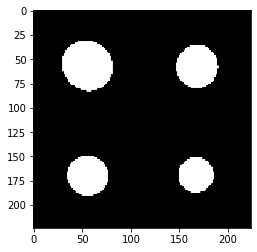

In [ ]:
randomindex=101
x_test_randomsample=x_test[randomindex]
plt.imshow(x_test_randomsample)

These are the actual values for the random samples

In [ ]:
y_true_randomsample=df_test.iloc[randomindex]
print("True Values for random sample")
print(y_true_randomsample)

True Values for random sample
img_path           drive/MyDrive/synthetic_shape_data_all/sph_D04...
shape                                                            sph
L                                                                 40
W                                                                 40
H                                                                 40
x                                                                259
y                                                               1358
z                                                                496
a                                                                329
b                                                                199
c                                                                289
d1                                                              1818
d2                                                              2064
d3                                                              2133
d4  

These are our predicted values

In [ ]:
y_pred_randomsample=ypredB.iloc[randomindex]
print("Predictions from Model B")
print(y_pred_randomsample)


Predictions from Model B
shape                 sph
L               34.166553
W               37.889671
H               37.703247
a              183.215271
b              180.078888
c              187.963531
volume              25543
surfacearea          4065
Name: 101, dtype: object


### Here we have calculated the accuracy for individual class for shape classification

The column shape contains the actual shape and the column predicted_shape contains the shape predicted by VGG16 fine-tuned model in following dataset

In [ ]:
df_test.head()

,img_path,shape,L,W,H,x,y,z,a,b,c,d1,d2,d3,d4,predicted_shape
0,drive/MyDrive/synthetic_shape_data_all/cyl_L02...,cyl,20,50,50,568,1245,737,114,68,348,2446,2005,2650,2217,cyl
1,drive/MyDrive/synthetic_shape_data_all/sph_D01...,sph,12,12,12,334,705,109,272,262,271,1922,1596,1741,1340,sph
2,drive/MyDrive/synthetic_shape_data_all/cyl_L04...,cyl,40,50,50,545,1052,680,278,44,241,2002,2445,2090,2534,cyl
3,drive/MyDrive/synthetic_shape_data_all/sph_D00...,sph,8,8,8,293,608,220,69,82,75,1597,1903,1236,1623,sph
4,drive/MyDrive/synthetic_shape_data_all/cyl_L04...,cyl,40,10,10,584,707,394,196,53,26,2382,1912,2262,1717,cyl


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(df_test['shape'], df_test['predicted_shape'])

(array([0.94923858, 1.        , 0.93203883]),
 array([0.935     , 0.972     , 0.97959184]),
 array([0.94206549, 0.98580122, 0.95522388]),
 array([200, 250, 196]))

In [ ]:
df_test_cyl=df_test[df_test['shape']=='cyl']
df_test_cub=df_test[df_test['shape']=='cub']
df_test_sph=df_test[df_test['shape']=='sph']

In [ ]:
from sklearn.metrics import accuracy_score
acc_cyl = accuracy_score(df_test_cyl['shape'], df_test_cyl['predicted_shape'])
acc_cub = accuracy_score(df_test_cub['shape'], df_test_cub['predicted_shape'])
acc_sph = accuracy_score(df_test_sph['shape'], df_test_sph['predicted_shape'])
print(f'Accuracy score for cylinder class is  {acc_cyl:0.2f}')
print(f'Accuracy score for cube class is  {acc_cub:0.2f}')
print(f'Accuracy score for sphere class is  {acc_sph:0.2f}')


Accuracy score for cylinder class is  0.97
Accuracy score for cube class is  0.94
Accuracy score for sphere class is  0.98


We see that accuracy is most for the sphere class, then for cylinder and least for cube

### Bar plots for mse of Volume and Surface area from L, W, H predictions"

Text(0.5, 1.0, 'Bar graph for volume prediction from the different models')

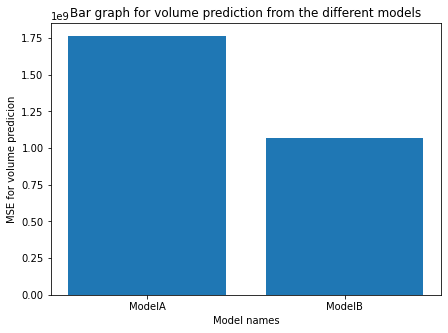

In [ ]:
# plotting mse of volume of all the Model in form of bar chart
fig = plt.figure(figsize=(7,5))
plt.bar(['ModelA','ModelB'],[mseA['volume'],mseB['volume']])
plt.xlabel('Model names')
plt.ylabel('MSE for volume predicion')
plt.title('Bar graph for volume prediction from the different models')

Text(0.5, 1.0, 'Bar graph for surface area prediction from the different models')

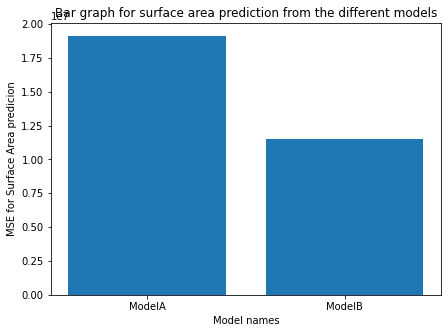

In [ ]:
# plotting mse of surface area of all the Model in form of bar chart
fig = plt.figure(figsize=(7,5))
plt.bar(['ModelA','ModelB'],[mseA['surfacearea'],mseB['surfacearea']])
plt.xlabel('Model names')
plt.ylabel('MSE for Surface Area predicion')
plt.title('Bar graph for surface area prediction from the different models')

### Checking predictions for one of sphere, cube and cylinder images

In [ ]:
index_sph = df_test[df_test['shape']=='sph'].index[0]
index_cub = df_test[df_test['shape']=='cub'].index[0]
index_cyl = df_test[df_test['shape']=='cyl'].index[0]
print(index_sph, index_cub, index_cyl)

1 8 0


In [ ]:
ytrueB.iloc[[index_sph, index_cub, index_cyl]]

,shape,L,W,H,a,b,c,volume,surfacearea
1,sph,12,12,12,272,262,271,904,452
8,cub,3,3,3,22,83,93,27,54
0,cyl,20,50,50,114,68,348,157000,31400


In [ ]:
ypredB.iloc[[index_sph, index_cub, index_cyl]].round(2)

,shape,L,W,H,a,b,c,volume,surfacearea
1,sph,11.93,12.940000,12.770000,175.919998,173.309998,180.710007,1032,485
8,sph,3.27,3.290000,3.330000,169.699997,167.210007,174.309998,19,34
0,cyl,15.93,37.950001,37.009998,185.649994,182.279999,190.389999,70235,17420


### Summarizing the results of our best model for L,W,H and a,b,c predictions

In [ ]:
# Our best model was modelB
print(f"MSE on test set for Length prediction with out best model was {mseB['L']:0.2f}")
print(f"MSE on test set for Width prediction with out best model was {mseB['W']:0.2f}")
print(f"MSE on test set for Height prediction with out best model was {mseB['H']:0.2f}")
print(f"MSE on test set for Orientation a prediction with out best model was {mseB['a']:0.2f}")
print(f"MSE on test set for Orientation b prediction with out best model was {mseB['b']:0.2f}")
print(f"MSE on test set for Orientation c prediction with out best model was {mseB['c']:0.2f}")

MSE on test set for Length prediction with out best model was 30.76
MSE on test set for Width prediction with out best model was 19.01
MSE on test set for Height prediction with out best model was 19.72
MSE on test set for Orientation a prediction with out best model was 11358.69
MSE on test set for Orientation b prediction with out best model was 10238.18
MSE on test set for Orientation c prediction with out best model was 10795.56


**NOTE : MSE is not the most appropriate loss function here, A custom loss function would have been more relevant. So the high MSE is not because the model didn't learn, It is only due to choice of a sub-optimal loss function.Will update that too in the future commits.**